In [76]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm, neighbors
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import warnings

output_dir = "USDA-NASS--v01/OUTPUTS/"
archive_dir = "ML-ARCHIVES--v01/"
tif_dir = "GAEZ-SOIL-for-ML/OUTPUTS/"
out_dir = archive_dir + "WEATHER-DATA--v01/"
weather_dir = archive_dir + "WEATHER-DATA--v01/"
ml_tables_dir = archive_dir + "ML-TABLES--v01/"


In [6]:
def plot_predictions(y_test, y_pred, descrip_of_run):
    # Check if the arrays have the same length
    if len(y_test) != len(y_pred):
        raise ValueError("The input arrays must have the same length.")

    # Create a scatter plot
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color="red", linestyle="--")  # Line y_pred = y_test
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.title("Predicted vs Actual for " + descrip_of_run)
    plt.grid(True)
    plt.show()

## Load ML files

In [7]:
ml_file = "ML-table-monthly.csv"

df_ml = pd.read_csv(ml_tables_dir + ml_file)
print(df_ml.shape)
df_ml


(9952, 72)


,year,state_name,county_name,yield,nutr_ret_high,suit_irrig_high_soy,AEZ_1,AEZ_2,AEZ_3,AEZ_4,...,month_05__PRECTOTCORR,month_05__GWETROOT,month_05__EVPTRNS,month_05__ALLSKY_SFC_PAR_TOT,month_06__T2M_MAX,month_06__T2M_MIN,month_06__PRECTOTCORR,month_06__GWETROOT,month_06__EVPTRNS,month_06__ALLSKY_SFC_PAR_TOT
0,2022,ILLINOIS,BUREAU,67.5,10,10000,False,True,False,False,...,67.10,0.551000,0.582333,2640.65,18.133871,4.468065,49.51,0.540323,0.098065,2086.28
1,2021,ILLINOIS,BUREAU,66.4,10,10000,False,True,False,False,...,26.31,0.508333,0.164667,2731.53,19.612903,9.828710,180.94,0.574839,0.146129,1541.99
2,2020,ILLINOIS,BUREAU,64.8,10,10000,False,True,False,False,...,143.42,0.589333,0.701667,2225.40,15.380000,3.402581,60.87,0.588387,0.202903,1705.02
3,2019,ILLINOIS,BUREAU,57.4,10,10000,False,True,False,False,...,245.06,0.650667,1.087000,2281.52,15.046774,4.569355,117.51,0.735484,0.254194,1682.48
4,2018,ILLINOIS,BUREAU,68.5,10,10000,False,True,False,False,...,86.09,0.581667,0.929333,2444.94,16.171613,4.874194,104.68,0.610968,0.216774,1708.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9947,2007,OHIO,WASHINGTON,36.0,9,10000,False,False,True,False,...,48.26,0.455667,0.354333,2901.61,22.918065,10.003548,65.25,0.456129,0.133871,1902.21
9948,2006,OHIO,WASHINGTON,39.9,9,10000,False,False,True,False,...,130.96,0.499000,0.550000,2102.77,16.437742,5.324839,122.71,0.570645,0.475161,1718.10
9949,2005,OHIO,WASHINGTON,34.9,9,10000,False,False,True,False,...,30.55,0.459333,0.436333,2863.84,19.583871,7.019355,105.37,0.493871,0.200968,1702.55
9950,2004,OHIO,WASHINGTON,46.7,9,10000,False,False,True,False,...,200.16,0.596667,1.371667,2641.88,18.884516,7.107419,87.45,0.608710,0.651935,1754.56


## Remove rows that have null values

In [8]:
has_null = np.array([np.sum(x) for x in df_ml.isnull().values])

In [9]:
df_ml = df_ml[np.where(has_null > 0, False, True)]

## Separate into features and labels

In [42]:
X = df_ml.drop(columns=["yield"])
y = df_ml.loc[:, ["yield"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
X_train.shape

(7961, 71)

In [44]:
X_test.shape

(1991, 71)

## Standard Scaler transformation

In [45]:
X_train = X_train.drop(columns=["year", "state_name", "county_name"])
X_test = X_test.drop(columns=["year", "state_name", "county_name"])


scalerXST = StandardScaler().fit(X_train)
scaleryST = StandardScaler().fit(y_train)

X_trainST = scalerXST.transform(X_train)
y_trainST = scaleryST.transform(y_train)
X_testST = scalerXST.transform(X_test)
y_testST = scaleryST.transform(y_test)

In [46]:
print(scaleryST.inverse_transform(y_testST)[0])

[39.6]


## Train lasso model

In [47]:
lassoST = Lasso(alpha=0.1)
lassoST.fit(X_trainST, y_trainST)

y_predST = lassoST.predict(X_testST)

In [48]:
rmseST = math.sqrt(mean_squared_error(y_testST, y_predST))

print(rmseST)


0.8394882389670729


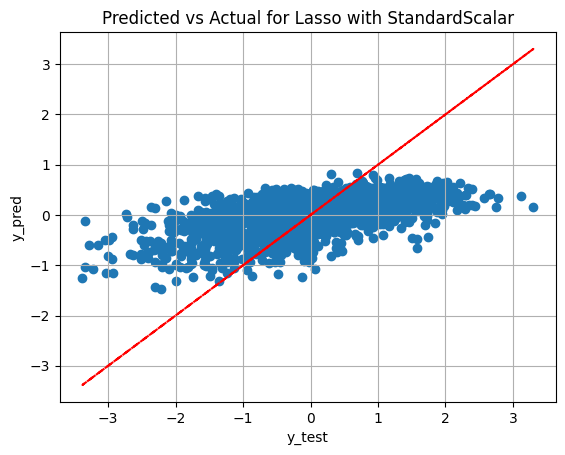

In [49]:
plot_predictions(y_testST, y_predST, "Lasso with StandardScalar")

## Train linear regression model

0.6885176288292456
0.5393898481758912


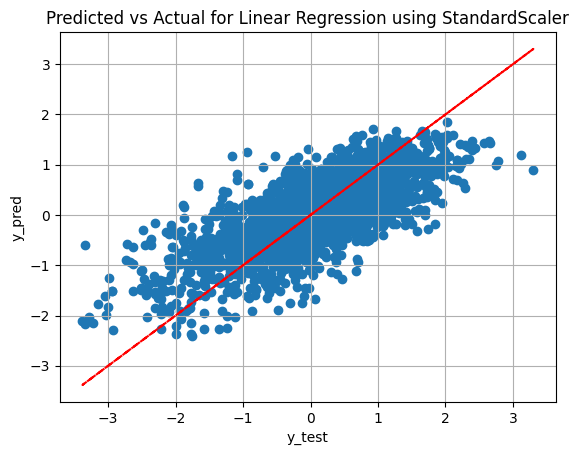

In [50]:
linearST = LinearRegression()
linearST.fit(X_trainST, y_trainST)

y_predST = linearST.predict(X_testST)

rmseST = math.sqrt(mean_squared_error(y_testST, y_predST))
print(rmseST)
r2ST = r2_score(y_testST, y_predST)
print(r2ST)

plot_predictions(y_testST, y_predST, "Linear Regression using StandardScaler")

## Min/Max scaling

In [51]:
scalerXMM = MinMaxScaler().fit(X_train)
scaleryMM = MinMaxScaler().fit(y_train)

X_trainMM = scalerXMM.transform(X_train)
y_trainMM = scaleryMM.transform(y_train)
X_testMM = scalerXMM.transform(X_test)
y_testMM = scaleryMM.transform(y_test)

## Linear regression with min/max scaling

0.09067521473279984
0.18135042946559968
0.538719221483047


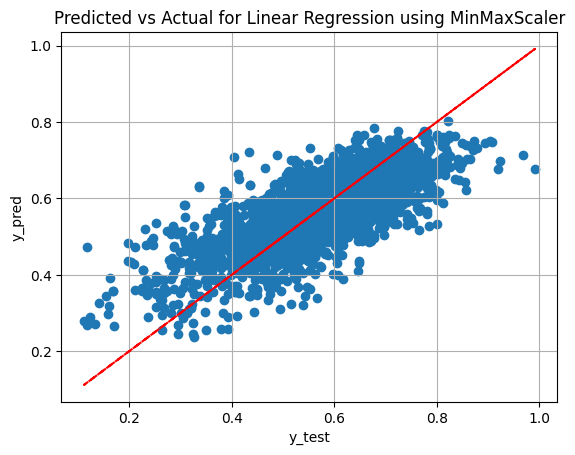

In [52]:
linearMM = LinearRegression()

linearMM.fit(X_trainMM, y_trainMM)

y_predMM = linearMM.predict(X_testMM)

rmseMM = math.sqrt(mean_squared_error(y_testMM, y_predMM))
rrmseMM = rmseMM / (0.5)
r2MM = r2_score(y_testMM, y_predMM)
print(rmseMM)
print(rrmseMM)
print(r2MM)

plot_predictions(y_testMM, y_predMM, "Linear Regression using MinMaxScaler")

0.5002613563830692
0.7568371139463831


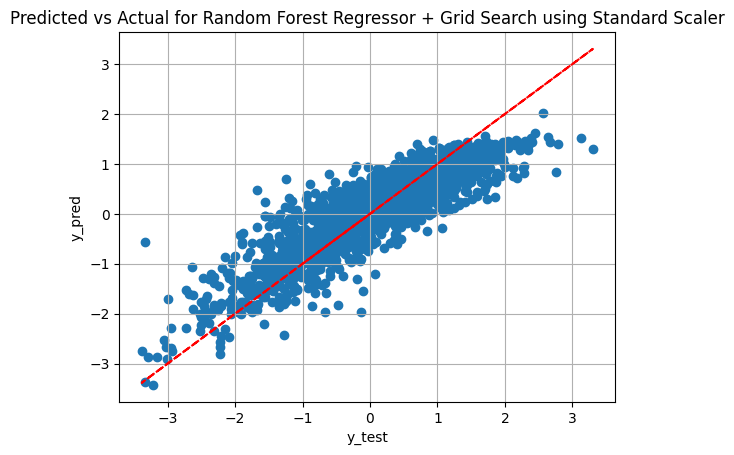

In [57]:
n_estimators = [10, 100]
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
param_grid = {
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split, 
    "n_estimators": n_estimators
}

regrRF = RandomForestRegressor()

gsh = HalvingGridSearchCV(
    estimator=regrRF, param_grid=param_grid, cv=5
)
gsh.fit(X_trainST, y_trainST.ravel())

y_predRFGS = gsh.predict(X_testST)
rmseRFGS = math.sqrt(mean_squared_error(y_testST, y_predRFGS))
r2RFGS = r2_score(y_testST, y_predRFGS)
print(rmseRFGS)
print(r2RFGS)

plot_predictions(y_testST, y_predRFGS, "Random Forest Regressor + Grid Search using Standard Scaler")

0.45833512884901306
0.7958874698087675


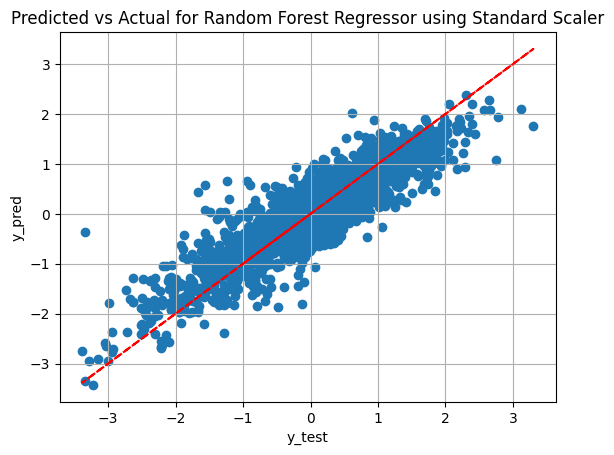

In [62]:
regrRF = RandomForestRegressor()

regrRF.fit(X_trainST, y_trainST.ravel())

y_predRF = regrRF.predict(X_testST)
rmseRF = math.sqrt(mean_squared_error(y_testST, y_predRF))
r2RF = r2_score(y_testST, y_predRF)
print(rmseRF)
print(r2RF)

plot_predictions(y_testST, y_predRF, "Random Forest Regressor using Standard Scaler")

0.5002613563830692
0.7568371139463831


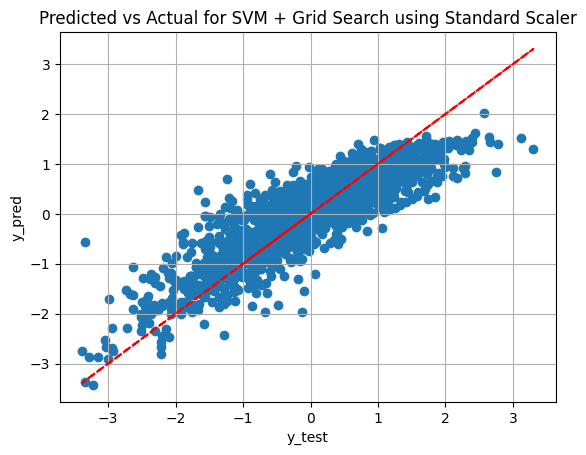

In [58]:
param_grid = {'kernel': ('linear', 'rbf'), 'C': [1, 10, 100]}

regrSVM = svm.SVR()

gshSVM = HalvingGridSearchCV(
    estimator=regrSVM, param_grid=param_grid, cv=5
)
gshSVM.fit(X_trainST, y_trainST.ravel())

y_predSVMGS = gshSVM.predict(X_testST)
rmseSVMGS = math.sqrt(mean_squared_error(y_testST, y_predSVMGS))
r2SVMGS = r2_score(y_testST, y_predSVMGS)
print(rmseSVMGS)
print(r2SVMGS)

plot_predictions(y_testST, y_predSVMGS, "SVM + Grid Search using Standard Scaler")

0.4621410575547817
0.7924835714558127


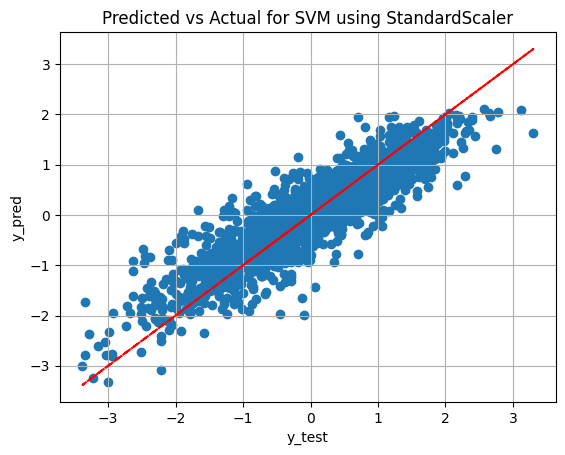

In [61]:
regrSVM = svm.SVR()
regrSVM.fit(X_trainST, y_trainST.ravel())

y_predSVM = regrSVM.predict(X_testST)

rmseSVM = math.sqrt(mean_squared_error(y_testST, y_predSVM))
print(rmseSVM)
r2SVM = r2_score(y_testST, y_predSVM)
print(r2SVM)

plot_predictions(y_testST, y_predSVM, "SVM using StandardScaler")

0.5247318713095468
0.7324664432818762


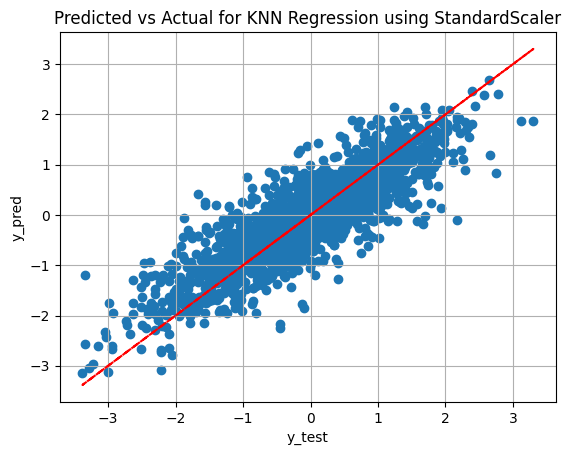

In [63]:
regrKNN = neighbors.KNeighborsRegressor(5, weights="uniform")
regrKNN.fit(X_trainST, y_trainST)

y_predKNN = regrKNN.predict(X_testST)

rmseKNN = math.sqrt(mean_squared_error(y_testST, y_predKNN))
print(rmseKNN)
r2KNN = r2_score(y_testST, y_predKNN)
print(r2KNN)

plot_predictions(y_testST, y_predKNN, "KNN Regression using StandardScaler")

0.5551439310911496
0.7005567211835022


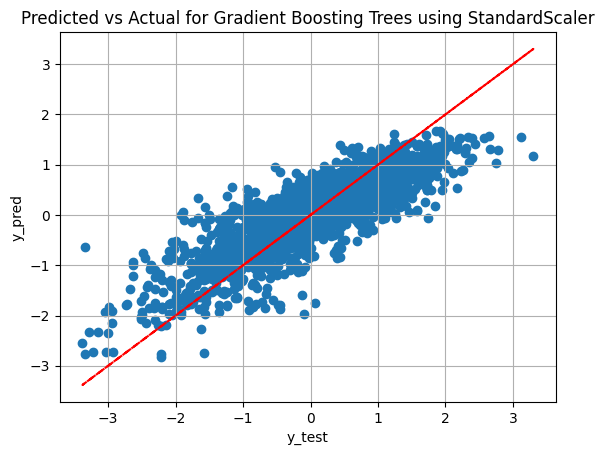

In [65]:
regrGBT = GradientBoostingRegressor()
regrGBT.fit(X_trainST, y_trainST.ravel())

y_predGBT = regrGBT.predict(X_testST)

rmseGBT = math.sqrt(mean_squared_error(y_testST, y_predGBT))
print(rmseGBT)
r2GBT = r2_score(y_testST, y_predGBT)
print(r2GBT)

plot_predictions(y_testST, y_predGBT, "Gradient Boosting Trees using StandardScaler")

0.5551439310911496
0.7005567211835022


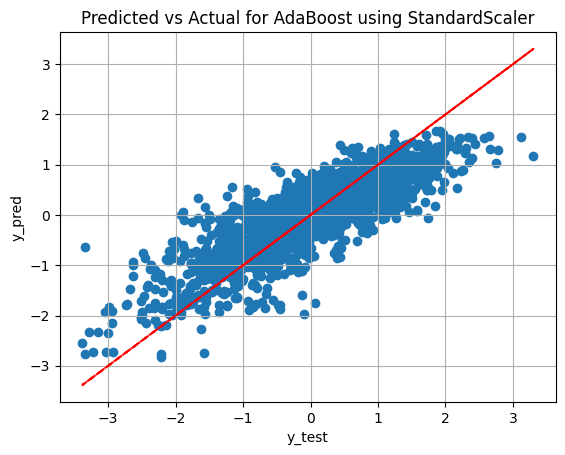

In [68]:
regrAda = AdaBoostRegressor()
regrAda.fit(X_trainST, y_trainST.ravel())

y_predAda = regrGBT.predict(X_testST)

rmseAda = math.sqrt(mean_squared_error(y_testST, y_predAda))
print(rmseAda)
r2Ada = r2_score(y_testST, y_predAda)
print(r2Ada)

plot_predictions(y_testST, y_predAda, "AdaBoost using StandardScaler")

In [69]:
min_features_to_select = 20  # Minimum number of features to consider
clf = LinearRegression()

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=5,
    scoring='r2',
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_trainST, y_trainST)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 60


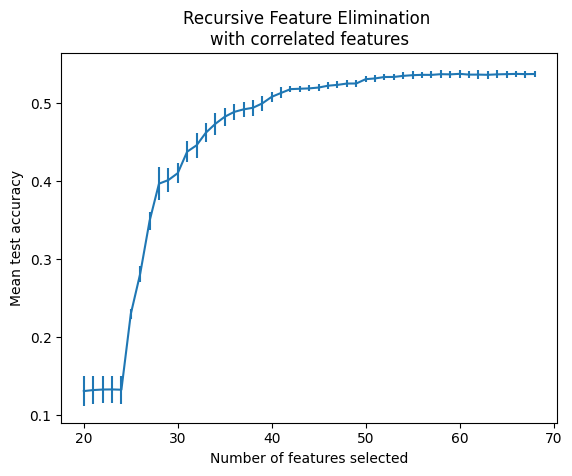

In [70]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [81]:
def plot_rfe(rfecv, min_features_to_select):
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.show()

def test_model(X_train, y_train, X_test, y_test, min_features_to_select, model=LinearRegression()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        min_features_to_select = min_features_to_select
        clf = model

        rfecv = RFECV(
            estimator=clf,
            step=1,
            cv=5,
            scoring='r2',
            min_features_to_select=min_features_to_select,
        )
        rfecv.fit(X_train, y_train)

        print(f"Optimal number of features: {rfecv.n_features_}")

        y_pred = rfecv.predict(X_test)

        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"RMSE: {rmse}")
        print(f"R-squared: {r2}")

        plot_rfe(rfecv, min_features_to_select)
        plot_predictions(y_test, y_pred, type(model).__name__)

Works with: LinearRegression, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

Optimal number of features: 60
RMSE: 0.6901931358390232
R-squared: 0.5371453317278163


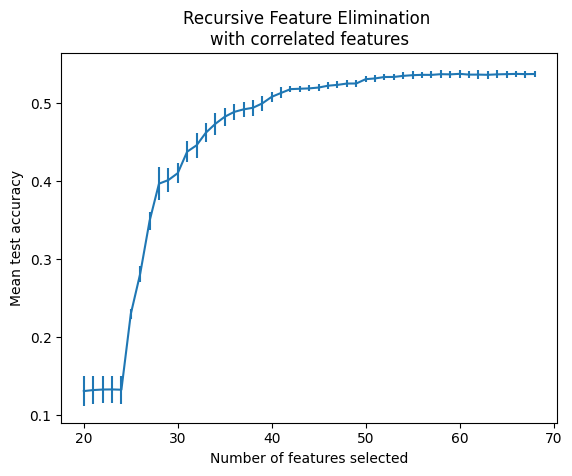

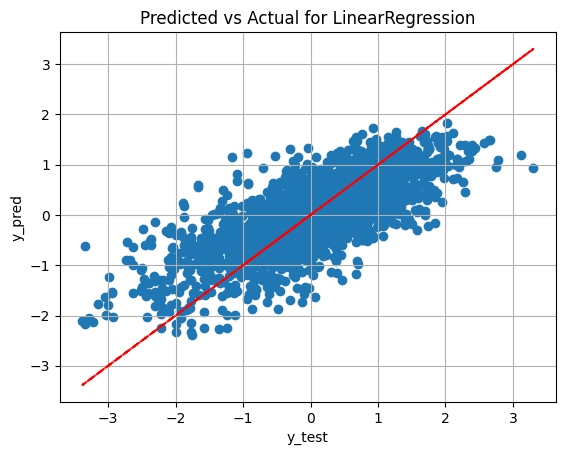

In [82]:
test_model(X_trainST, y_trainST, X_testST, y_testST, 20, model=LinearRegression())